# Count Most Frequent Words in Top Downloaded Books at Project Gutenberg Using Luigi Batch Scheduler Pipeline

*This code is heavily drawn from this excellent tutorial: https://www.digitalocean.com/community/tutorials/how-to-build-a-data-processing-pipeline-using-luigi-in-python-on-ubuntu-20-04'*

**Python libraries used:**  

*Luigi, BeautifulSoup, Requests, Pickle, Counter, File I/O*

**The codes in this notebook are meant to be executed from a local python file through a linux terminal. Data is also stored locally.**

We create and implement a pipeline of following tasks:

> 1. Get a list of top downloaded books from Project Gutenberg and store in a local file.  
> 2. Download a specifed number of books from the above list and pre-process their text. 
> 3. Count the most frequently occurring words across all specified books and display the summary.  

**Create demo directories**

mkdir luigi-demo  
cd luigi-demo  
mkdir data  
mkdir data/counts  
mkdir data/downloads  

**Create and activate a virtual environment**

python3 -m venv luigi-venv  
luigi-venv/bin/activate  

**Install relevant libraries**

pip install wheel luigi beautifulsoup4 requests  

**Create code file**

nano word-frequency.py  

## 1. Getting a list of top downloaded books

In [ ]:
import requests
import luigi
from bs4 import BeautifulSoup as bs

In [ ]:
class GetTopBooks(luigi.Task):
    
    
    # Specify local file to store urls of top downloaded books
    
    def output(self):
        
        return luigi.LocalTarget('data/book_list.txt')
    
    # Retreive urls of top downloaded books from website and storing in the local file
    
    def run(self):
        
        resp = requests.get('https://www.gutenberg.org/browse/scores/top')
        soup = bs(resp.content, 'html.parser')
        
        header = soup.find_all("h2", string="Top 100 EBooks yesterday")[0]
        top_list = header.find_next_sibling("ol")
        
        with self.output.open('w') as f:    
            for result in top_list.select('li>a'):
                if '/ebooks/' in result['href']:
                    
                    f.write('http://www.gutenberg.org{link}.txt.utf-8\n'.format(link=result['href']))       

**Initiate Task 1 from terminal using Luigi's local scheduler and checking results**

python -m luigi --module word-frequency GetTopBooks --local-scheduler  

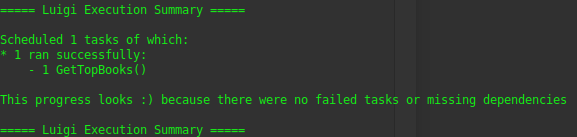

cat data/books_list.txt  

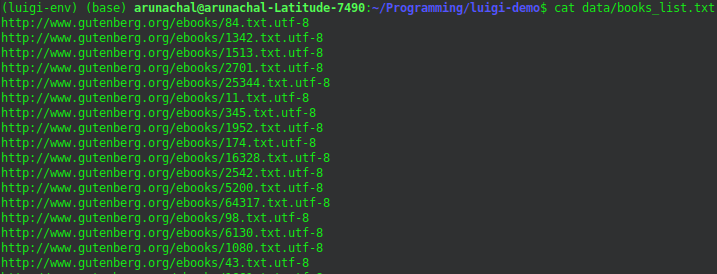

**Initiate Task 1 from terminal using Luigi's general scheduler and checking results**

**Allowing firewall permissions for Luigi Batch Scheduler**

sudo ufw allow 8082/tcp  
luigid --port 8082 > /dev/null 2> /dev/null &  

**Initiate task from terminal using Luigi's general scheduler and checking results**

python -m luigi --module word-frequency GetTopBooks   
cat data/books_list.txt  
http://localhost:8082/  

**Append code for next task in code file**

nano word-frequency.py  

## 2. Downloading books from the list and pre-processing text

In [ ]:
class DownloadBooks(luigi.Task):
    
    FileID = luigi.IntParameter()
    replace_list = """.,"';_[]:*-"""
    
    # Get previously stored urls as input
    
    def requires(self):
        return GetTopBooks()  
    
    
    # Specify local file to store downloaded books into
    
    def output(self):    
        return luigi.LocalTarget('data/downloads/{}.txt'.format(self.FileID))
    
    # Download a specific listed book, remove special characters, and change to lowercase
       
    def run(self):
    
        with self.input().open('r') as i:

            url = i.read().splitlines()[self.FileID]

            with self.output().open('w') as f:

                book = requests.get(url)
                book_text = book.text

                for char in replace_list:

                    book_text = book_text.replace(char, ' ')

                book_text = book_text.lower()
                f.write(book_text)    

**Allowing firewall permissions for Luigi Batch Scheduler**

sudo ufw allow 8082/tcp  
luigid --port 8082 > /dev/null 2> /dev/null &  

**Initiate Task 2 from terminal using Luigi's general scheduler and checking results**

python -m luigi --module word-frequency DownloadBooks --FileID 2  
http://localhost:8082/  

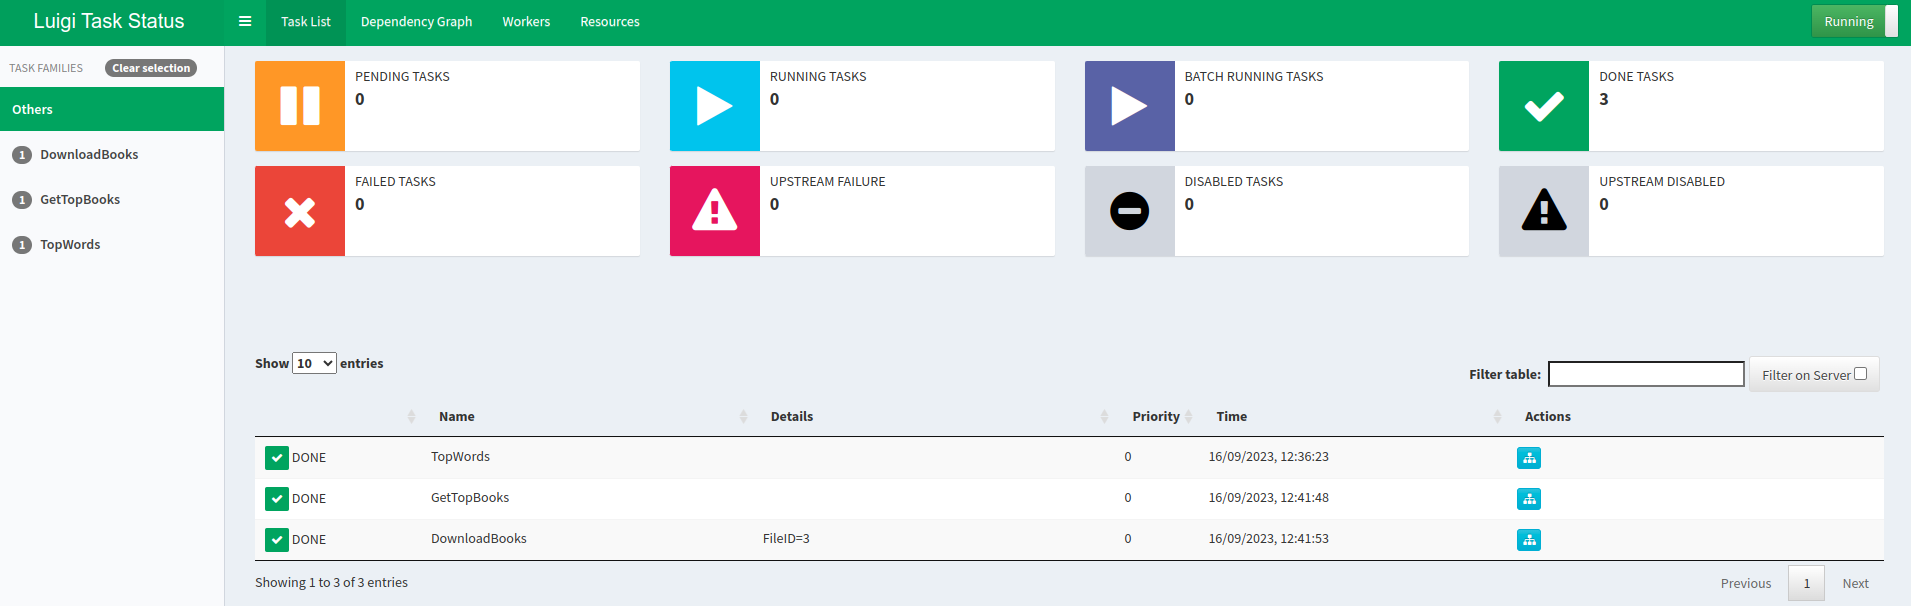


The downloaded book file and its text can be seen locally.  

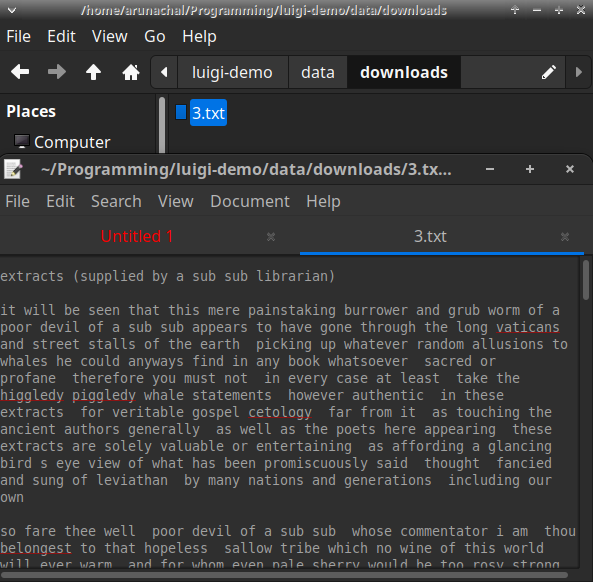

**Append code for next task in code file**  

nano word-frequency.py  

## 3. Counting most frequent words across all downloaded books and displaying summary

### Counting most frequent words for a test book and storing as a binary

In [ ]:
from collections import Counter
import pickle

In [ ]:
class CountWords(luigi.Task):
    
    # Obtain a specific downloaded book as an input
    
    def requires(self):
        
        return DownloadBooks(FileID=self.FileID)
    
    # Specify a local pickle file to store most frequent words with counts as binary
    
    def output(self):
        
        return luigi.LocalTarget('/data/counts/count_{}.pickle'.format(self.FileID), format=luigi.format.Nop)
    
    # Generate word frequency for the downloaded book and store as a binary
    
    def run(self):
        
        with self.input().open('r') as i:
            
            word_count = Counter(i.read().split())
            
            with self.output().open('w') as f:
                
                pickle.dump(word_count, f)

### Setting Luigi Configuration Parameters

In [ ]:
# Set global default parameters for number of books to download and number of most frequent words to report

class GlobalParams(luigi.Config):
    
    NumberBooks = luigi.IntParameter(default=10)
    NumberTopWords = luigi.IntParameter(default=500)

### Counting most frequent words across all specified books and displaying summary

In [ ]:
class TopWords(luigi.Task):
    
    # Retreive list of top downloaded books, download a specified number of books
    # Obtain count summary for all books as binary input array
    
    def requires(self):
        
        inputs = []
        
        for i in range(GlobalParams().NumberBooks):
            
            inputs.append(CountWords(FileID=i))
            
        return inputs
    
    # Specify local file to store count summaries into
    
    def output(self):
        
        return luigi.LocalTarget('data/summary.txt')
    
    # Retreive summary counts for each book from stored binaries
    # Merge into a combined summary and write into the destination file
    
    def run(self):
        
        total_count = Counter()
        
        for input in self.input():
            
            with input.open('rb') as i:
                
                nextCounter = pickle.load(i)
                total_count += nextCounter
                
            with self.output('w') as f:
                
                for item in total_count.most_common(GlobalParams().NumberTopWords):
                    
                    f.write('{0: <15}{1}\n'.format(*item))

**Initiate Task 3 from terminal using Luigi's general scheduler and checking results**

python -m luigi --module word-frequency TopWords --GlobalParams-NumberBooks 10 --GlobalParams-NumberTopWords 500  
cat data/summary.txt 

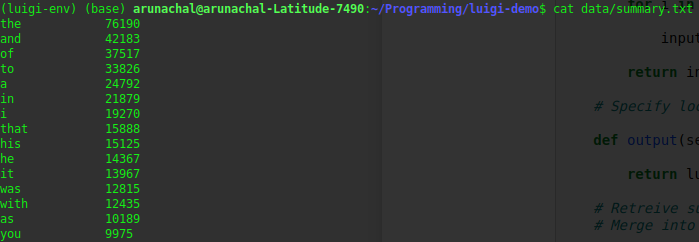

  
  
http://localhost:8082/    


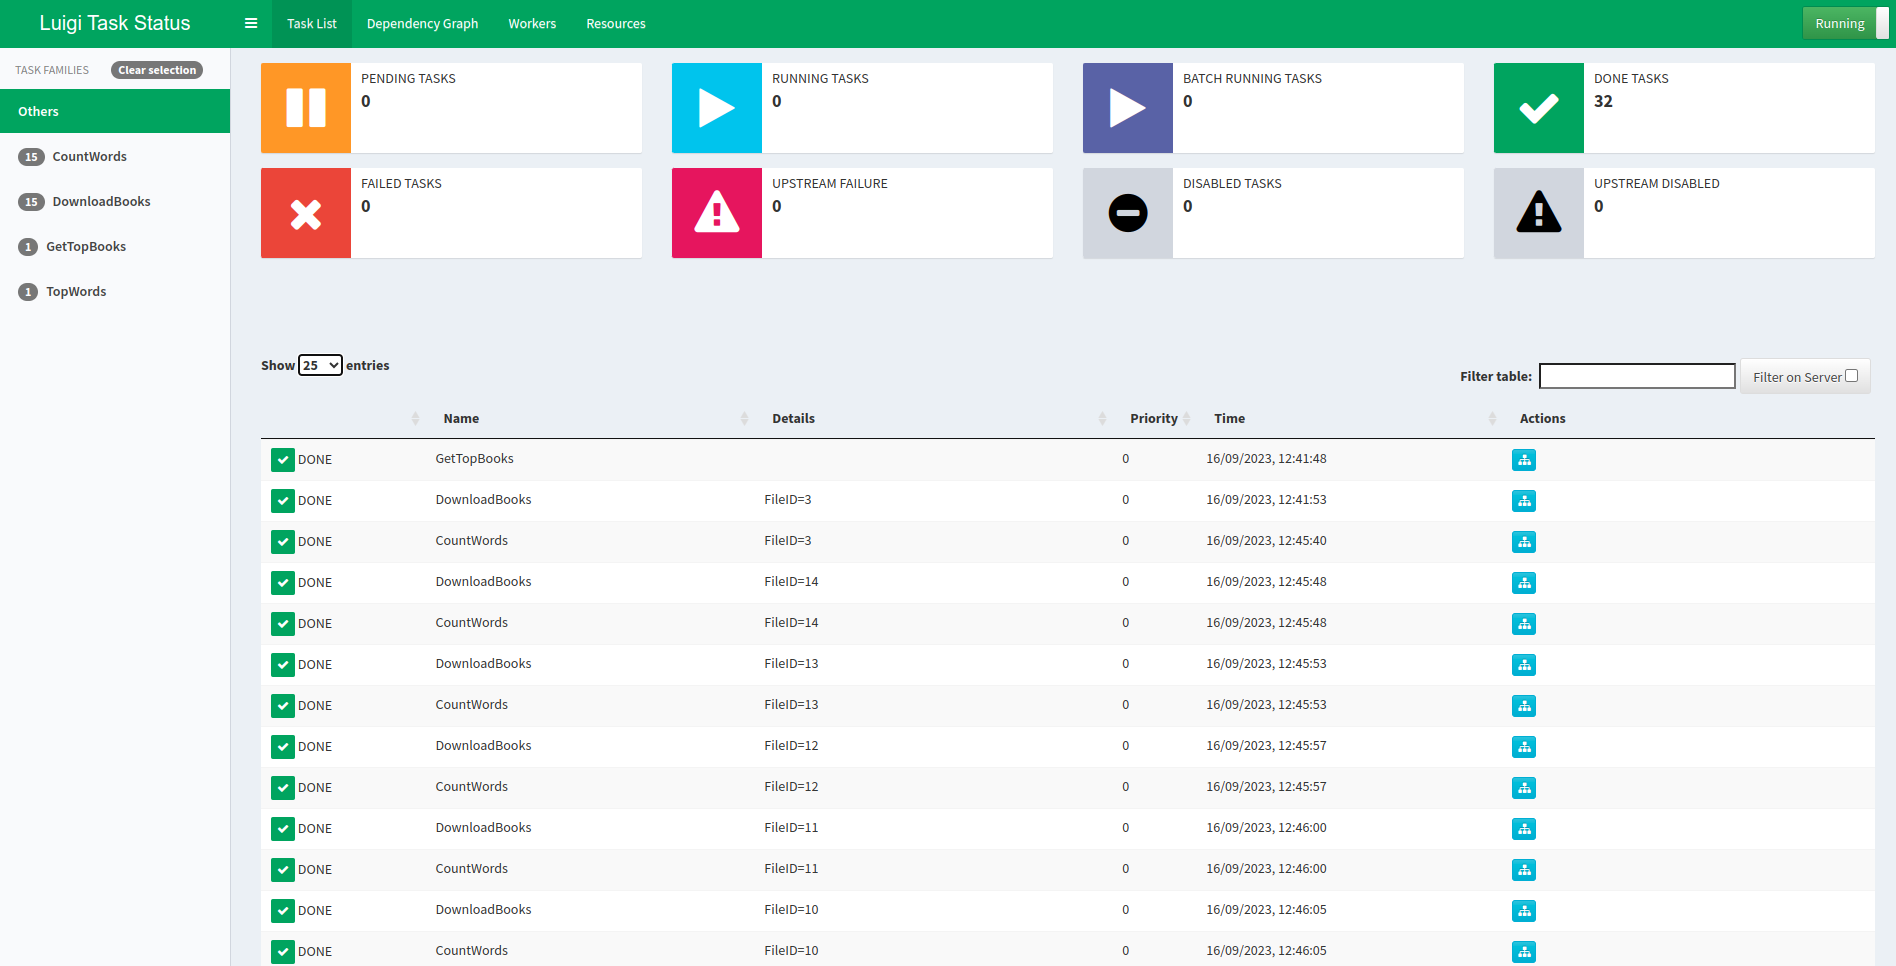

  
The downloaded books, binary files containing count summaries and the overall summary can be seen locally.  


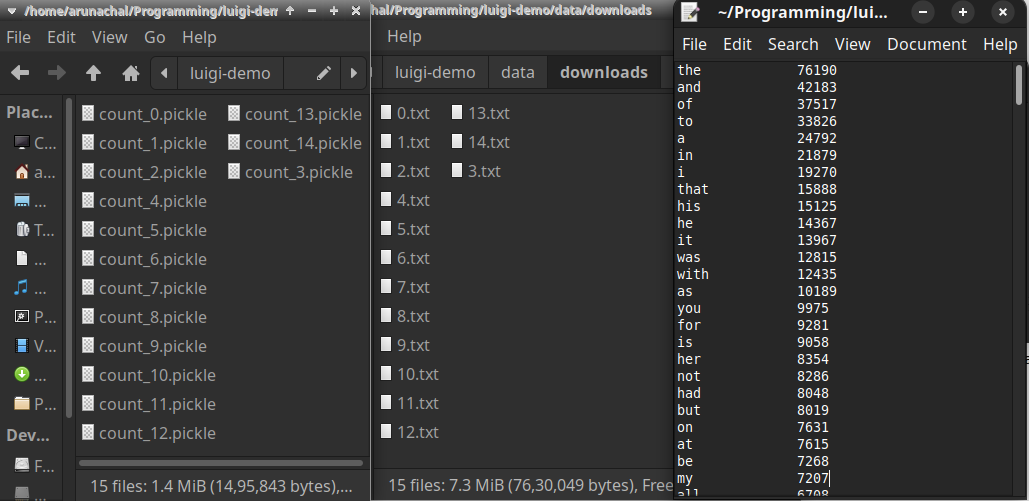  

The workflow execution graph can be seen on the local Luigi dashboard.  

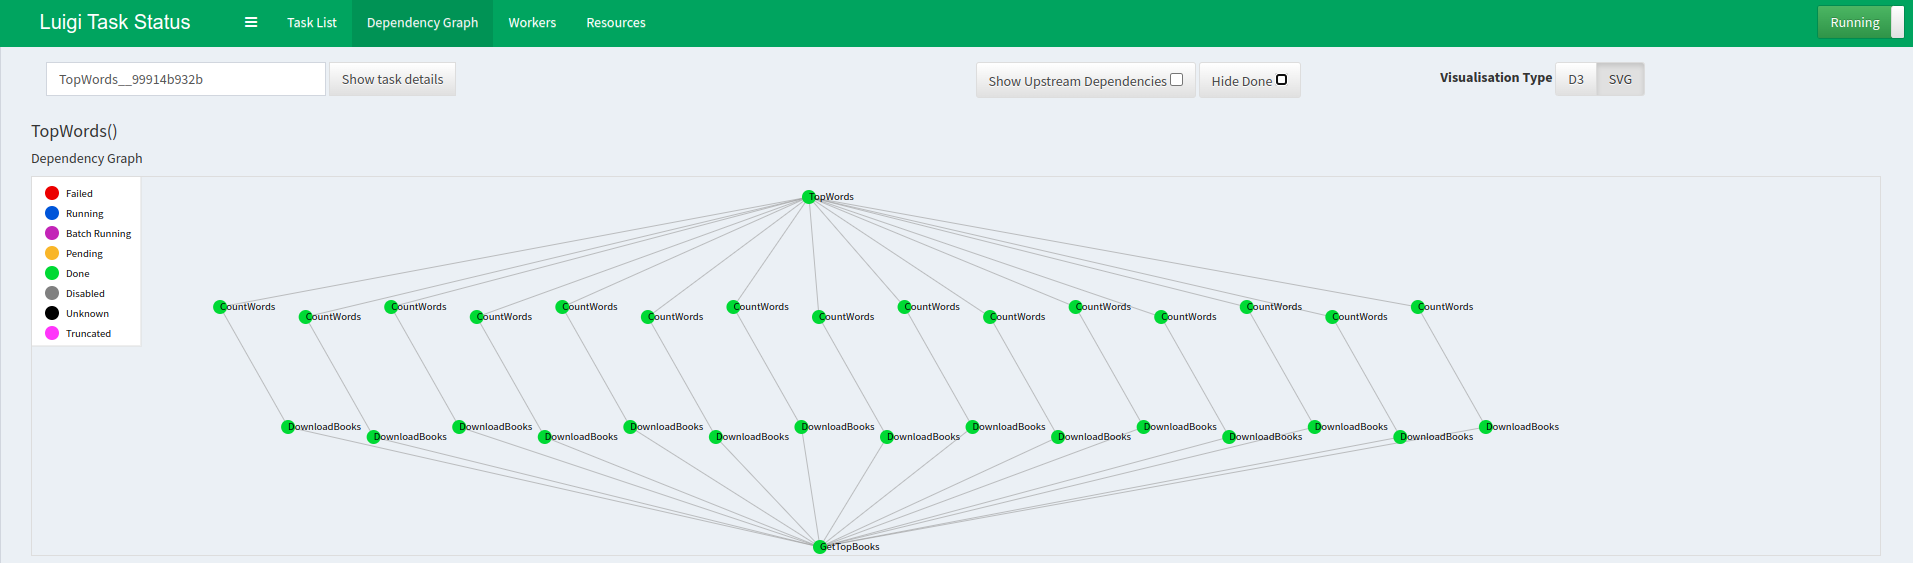